In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

## Data Loading and Exploration

In [127]:
# Load the dataset
df = pd.read_csv('customer_segmentation_data.csv')

# Display the first few rows of the dataset
print(df.head())

   minutes_watched     CLV  region  channel
0           3197.0  205.42       2        4
1             63.0  149.99       0        1
2            605.0  119.00       2        2
3             20.0  240.00       2        4
4            245.0  184.36       1        4


In [128]:
# Descriptive statistics of the dataset
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [129]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB
None


In [130]:
# Count of null values
df.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

The column 'minutes_watched' has null values that correspond to people who've entered the program, but have not seen any content. That's why it's most appropriate, instead of removing them from the dataset, to fill those missing values with zeroes instead.

## Data Cleaning and Preprocessing

In [131]:
# Fill missing values in 'minutes watched' with zeros
df['minutes_watched'].fillna(0, inplace=True)

# Check for any remaining missing values
print(df.isnull().sum())

minutes_watched    0
CLV                0
region             0
channel            0
dtype: int64


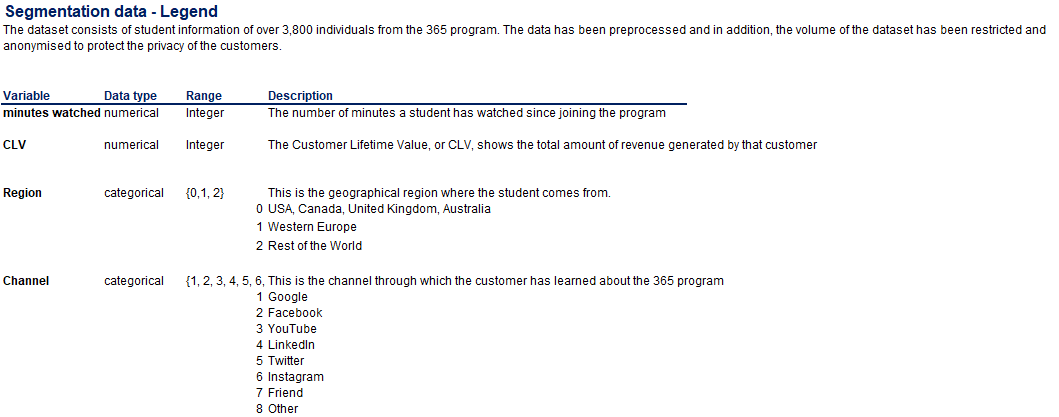

## Data Visualization and Correlation Analysis

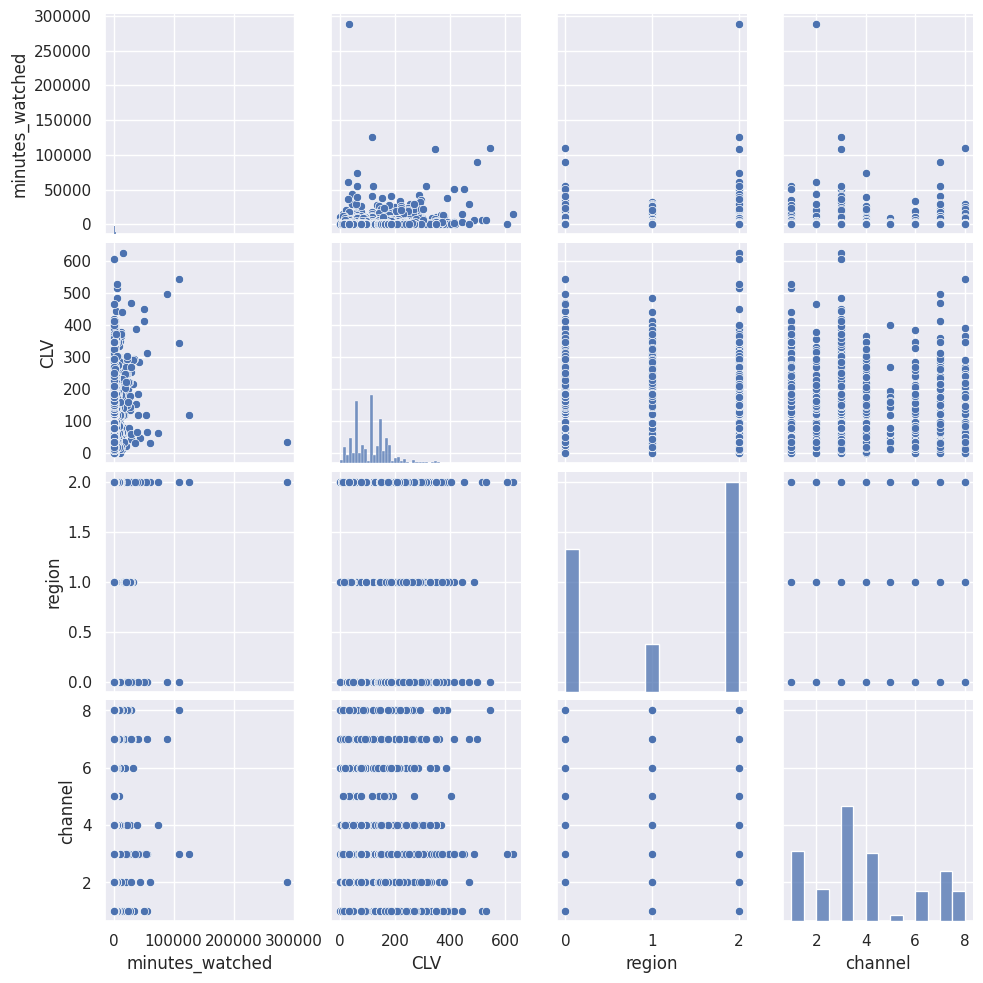

In [132]:
# Pairplot for a quick overview
sns.pairplot(df)
plt.show()

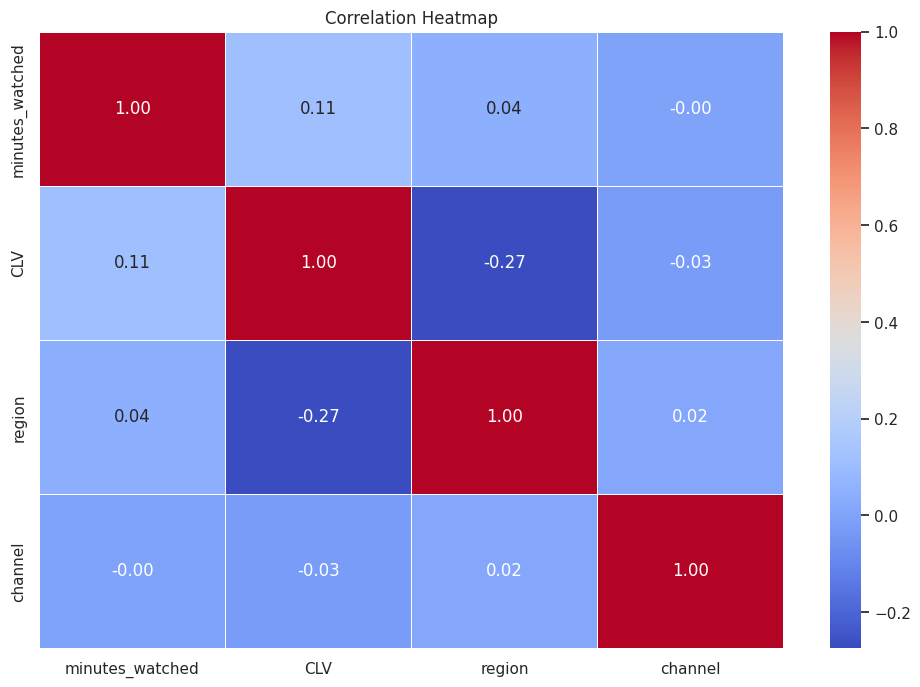

In [133]:
# Correlation analysis
correlation_matrix = df.corr()

# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

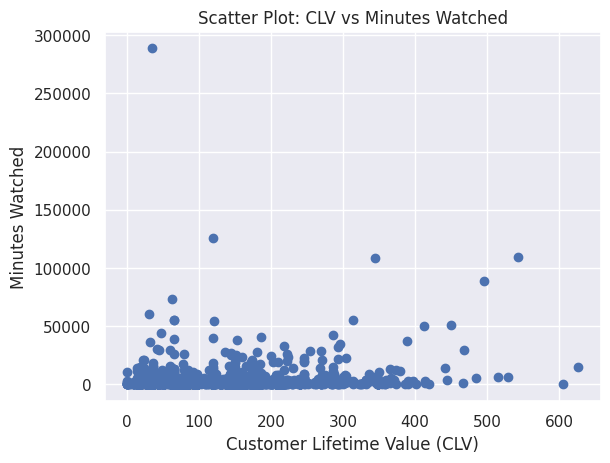

In [134]:
# Scatter plot between 'CLV' and 'minutes_watched'
plt.scatter(df['CLV'], df['minutes_watched'])
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Minutes Watched')
plt.title('Scatter Plot: CLV vs Minutes Watched')
plt.show()

## Create Dummy Variables

In [135]:
# Unique values in 'region' column
df.region.unique()

array([2, 0, 1])

In [136]:
# Unique values in 'channel' column
df.channel.unique()

array([4, 1, 2, 3, 8, 6, 7, 5])

In [137]:
# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['region', 'channel'])

# Display the updated dataframe
print(df.head())

   minutes_watched     CLV  region_0  region_1  region_2  channel_1  \
0           3197.0  205.42         0         0         1          0   
1             63.0  149.99         1         0         0          1   
2            605.0  119.00         0         0         1          0   
3             20.0  240.00         0         0         1          0   
4            245.0  184.36         0         1         0          0   

   channel_2  channel_3  channel_4  channel_5  channel_6  channel_7  channel_8  
0          0          0          1          0          0          0          0  
1          0          0          0          0          0          0          0  
2          1          0          0          0          0          0          0  
3          0          0          1          0          0          0          0  
4          0          0          1          0          0          0          0  


## Data standardization

In [138]:
# Standardize the data
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

## Hierarchical clustering

In [139]:
hier_clust = linkage(df_std, method = 'ward')

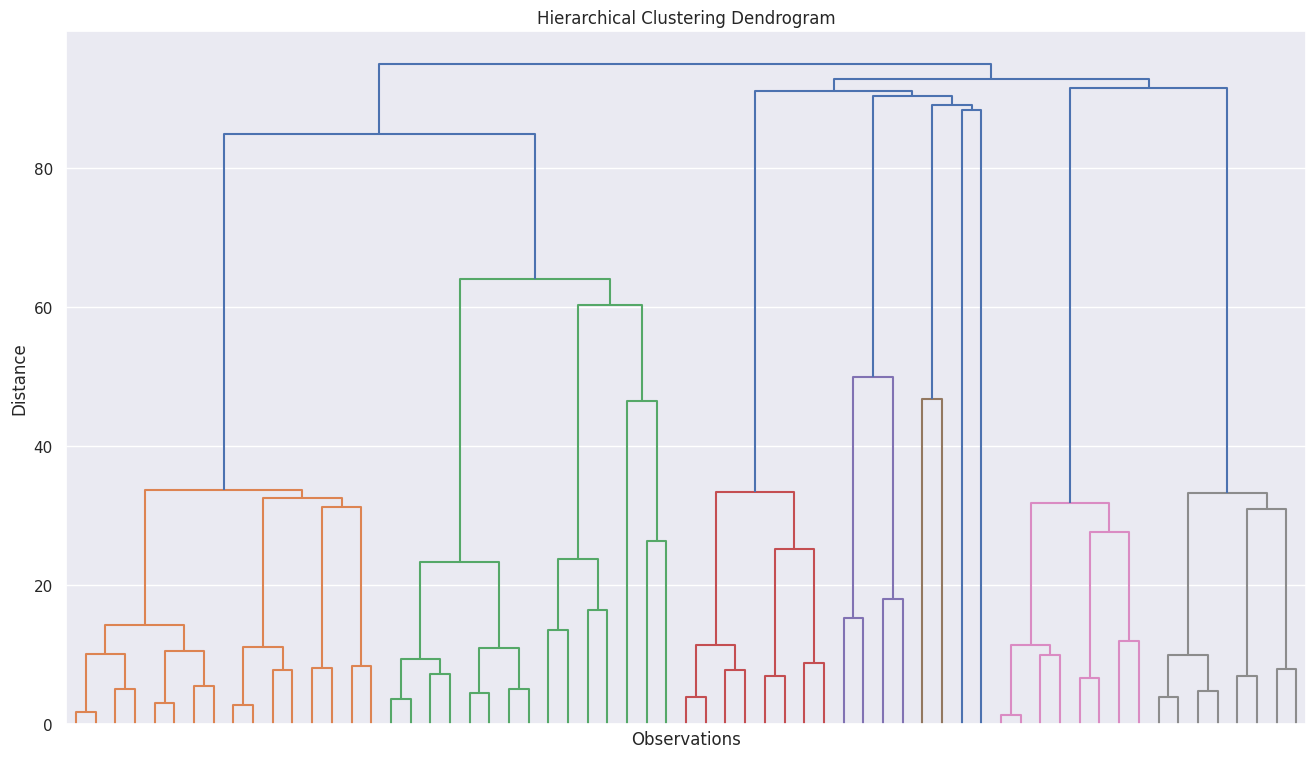

In [140]:
plt.figure(figsize = (16,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.savefig('hierarchical.png')
plt.show()

The results of the algorithm point to eight separate clusters.

## K-means clustering

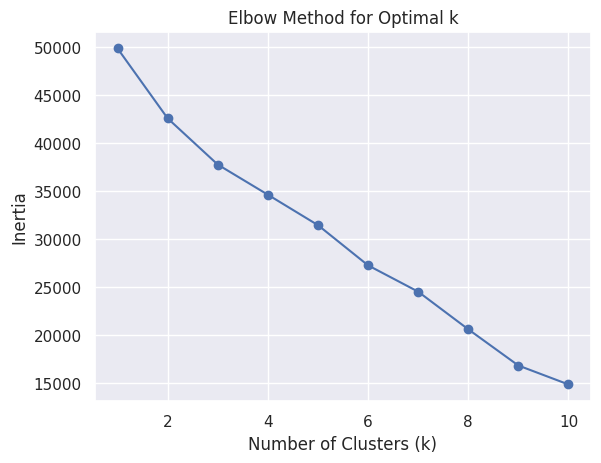

In [141]:
# Implement K-means and determine the optimal number of clusters using the Elbow Method
inertia_values = []
possible_k_values = range(1, 11)

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_std)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(possible_k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

 If we use the elbow method, we observe that the results of the k-means algorithm point to two, four, or nine different clusters. These results differ from the eight clusters found by the hierarchical clustering with the elbow method.

In this case, we’ll opt for the hierarchical clustering results and apply them in the k-means—i.e., perform k-means clustering with eight clusters and analyze the resulting clusters using a summary table.

In [142]:
# KMeans algorithm is initialized here with 8 clusters.
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42, n_init=10)

In [143]:
# Fitting the standardized data to the KMeans algorithm with 8 clusters.
kmeans.fit(df_std)

KMeans(n_init=10, random_state=42)

## Model Interpretation and Results

In [144]:
# Creating a copy of the original 'df' dataframe to avoid modifying it directly.
df_segm_kmeans = df.copy()

# Assigning the cluster labels generated by k-means to a new column named 'Segment' in the copied dataframe.
df_segm_kmeans['Segment'] = kmeans.labels_

In [145]:
# Grouping the dataframe by the 'Segment' column and calculating the mean for each segment.
# This provides a profile for each cluster based on the mean values of the original features.
df_segm_analysis = df_segm_kmeans.groupby(['Segment']).mean()

# Displaying the segmented analysis
df_segm_analysis

,minutes_watched,CLV,region_0,region_1,region_2,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
Segment,,,,,,,,,,,,,
0,1589.376923,107.368708,0.290769,0.107692,0.601538,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0
1,2397.181658,104.035520,0.017637,0.005291,0.977072,0.0,0.0,0.897707,0.0,0.102293,0.0,0.0,0.0
2,2006.190377,113.654038,0.257322,0.112971,0.629707,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0
3,2767.643791,108.260359,0.287582,0.101307,0.611111,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,1810.359165,121.154173,0.390462,0.120715,0.488823,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
5,2314.083333,123.189965,0.513889,0.138889,0.347222,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0
6,1299.332180,115.180277,0.311419,0.190311,0.498270,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0
7,1523.389744,149.729214,0.779487,0.217094,0.003419,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0


In [146]:
# Counting the number of observations in each segment.
# This is done by grouping by 'Segment' and counting the occurrences.
# 'Region_0' is used arbitrarily to count, as it exists in each segment.
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment','region_0']].groupby(['Segment']).count()

# Calculating the proportion of observations in each segment.
# This is done by dividing the number of observations in a segment by the total number of observations.
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [147]:
# Rounding the dataframe values to 2 decimal places for cleaner presentation.
df_segm_analysis.round(2)

,minutes_watched,CLV,region_0,region_1,region_2,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,
0,1589.38,107.37,0.29,0.11,0.60,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,650,0.17
1,2397.18,104.04,0.02,0.01,0.98,0.0,0.0,0.9,0.0,0.1,0.0,0.0,0.0,567,0.15
2,2006.19,113.65,0.26,0.11,0.63,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,478,0.12
3,2767.64,108.26,0.29,0.10,0.61,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,306,0.08
4,1810.36,121.15,0.39,0.12,0.49,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,671,0.18
5,2314.08,123.19,0.51,0.14,0.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,288,0.08
6,1299.33,115.18,0.31,0.19,0.50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,289,0.08
7,1523.39,149.73,0.78,0.22,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,585,0.15


In [148]:
# Renaming the index labels (which are segment numbers) with more descriptive names.
# This provides a more interpretable profile for each cluster.
df_segm_analysis.rename({0:'Instagram Explorers',
                         1:'LinkedIn Networkers',
                         2:'Friends\' Influence',
                         3:'Google-YouTube Mix',
                         4:'Anglo-Saxon Multi-Channel',
                         5:'European Multi-Channel',
                         6:'Twitter Devotees',
                         7:'Facebook Followers',
                        })

,minutes_watched,CLV,region_0,region_1,region_2,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,
Instagram Explorers,1589.376923,107.368708,0.290769,0.107692,0.601538,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,650,0.169536
LinkedIn Networkers,2397.181658,104.035520,0.017637,0.005291,0.977072,0.0,0.0,0.897707,0.0,0.102293,0.0,0.0,0.0,567,0.147887
Friends' Influence,2006.190377,113.654038,0.257322,0.112971,0.629707,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,478,0.124674
Google-YouTube Mix,2767.643791,108.260359,0.287582,0.101307,0.611111,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,306,0.079812
Anglo-Saxon Multi-Channel,1810.359165,121.154173,0.390462,0.120715,0.488823,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,671,0.175013
European Multi-Channel,2314.083333,123.189965,0.513889,0.138889,0.347222,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,288,0.075117
Twitter Devotees,1299.332180,115.180277,0.311419,0.190311,0.498270,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,289,0.075378
Facebook Followers,1523.389744,149.729214,0.779487,0.217094,0.003419,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,585,0.152582


In [149]:
# Mapping the cluster numbers (Segment) to more human-readable labels using a dictionary.
# This helps in interpreting the clusters in plots and other visualizations.
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment'].map({0:'Instagram Explorers',
                         1:'LinkedIn Networkers',
                         2:'Friends\' Influence',
                         3:'Google-YouTube Mix',
                         4:'Anglo-Saxon Multi-Channel',
                         5:'European Multi-Channel',
                         6:'Twitter Devotees',
                         7:'Facebook Followers',
                        })

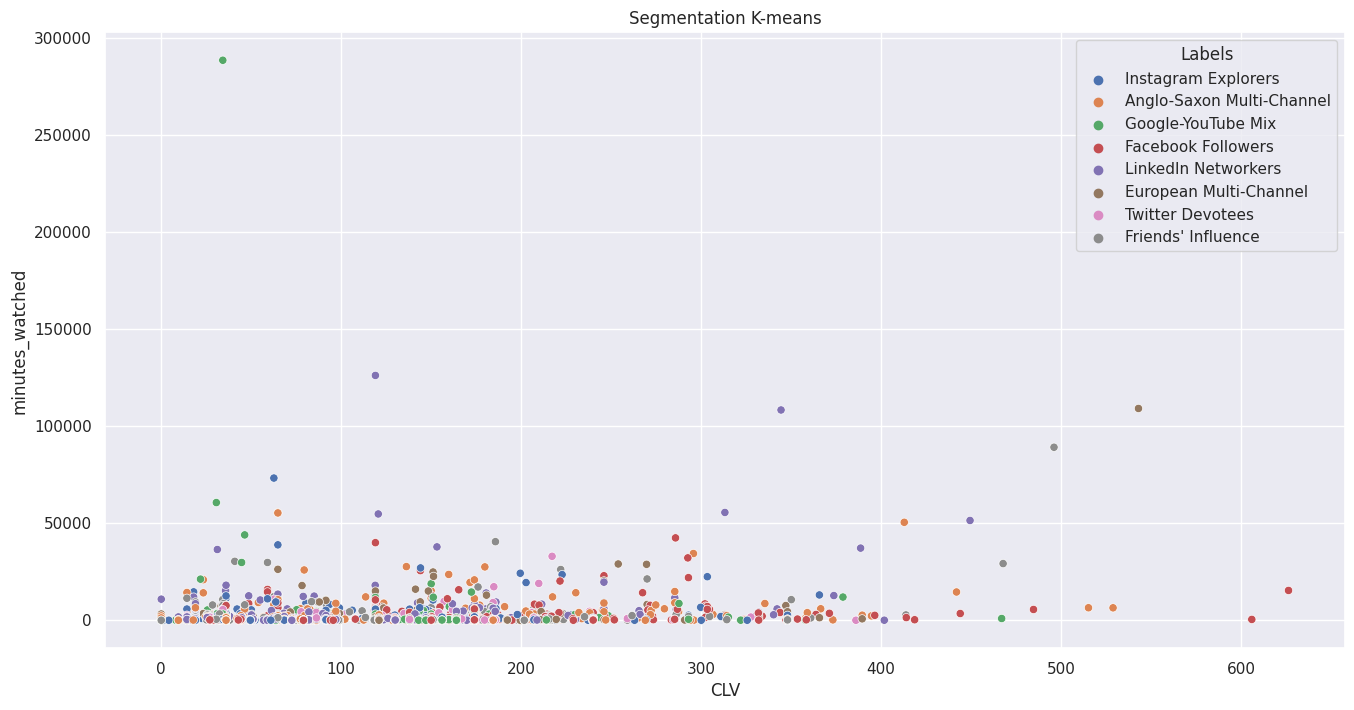

In [150]:
# Defining the x-axis data as 'total_payments' from the dataframe.
x_axis = df_segm_kmeans['CLV']

# Defining the y-axis data as 'minutes_watched' from the dataframe
y_axis = df_segm_kmeans['minutes_watched']

# Setting the figure size for the scatter plot.
plt.figure(figsize = (16, 8))

# The 'hue' parameter colors the points based on the 'Labels' column, allowing for distinction between clusters.
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_kmeans['Labels'])

# Setting the title of the scatter plot.
plt.title('Segmentation K-means')

# Displaying the scatter plot.
plt.show()